# Redes Neurais

In [62]:
using Plots
gr(size=(600,400))
default(fmt=:png)

using Logging
Logging.disable_logging(Logging.Info)

LogLevel(1)

Considere a identificação de um número numa imagem.

In [63]:
using Flux.Data.MNIST

imgs = MNIST.images()
imgs[2]

In [64]:
labels = MNIST.labels()
labels[2]

0

- Essa imagem tem 28 por 28 pixels, e indica uma escala de cinza (0 - preto e 1 - branco).
- A partir da imagem, queremos identificar o dígito: 0, 1, ..., 9
- Consideramos como um indivíduo $x^i$ o vetor de cada valor de entrada, isto é, $x \in \mathbb{R}^{784}$
- Consideramos para classificação, um vetor $y \in \mathbb{R}^{10}$, onde $y_j = 1$ se $x$ é da classe $j$, e 0 para os outros $y_k$, $k \neq j$. As classes serão os dígitos 0 a 9.
- A rede neural, consiste em estabelecer camadas de valores, como camadas de neurônios, e entre elas ligações, como sinapses.
- A primeira camada é a de entrada (input), que no nosso caso consiste da imagem.
- A última camada é a de saída (output), que consiste na classificação.
- Entre estas camadas, podemos ter camadas escondidas.
- Em cada nó, podemos ter funções de ativações.

## Rede neural simples, sem camadas escondidas

- Temos $x_1,\dots,x_N$ de entrada e $y \in \mathbb{R}$ de saída.
- Nosso modelo é $h(x) = \sigma(w^T x + b)$, onde $\sigma$ é a função de ativação. Podemos ter $\sigma(x) = x$, para ter um modelo linear, como o de regressão linear, ou $\sigma(x) = (1 + e^{-x})^{-1}$ para um modelo logístico, como e de regressão logística, mas também podemos escolher outros valores para $\sigma$.
- Escolhido o modelo $h$, temos o nosso erro, que é dado por uma função de perda $\ell(\hat{y}, y)$.
- Considerando os dados $(x^i,y^i), i = 1,\dots,m$, temos
$$ L = \frac{1}{m}\sum_{i=1}^m \ell(h(x^i), y^i). $$

- Note que até então, temos exatamente regressão linear (e polinomial e múltipla) se $\ell(\hat{y}, y) = \frac{1}{2}\| \hat{y} - y\|^2$.
- Também temos a regressão logística se $\ell(\hat{y}, y) = -y\ln\hat{y} - (1 - y)\ln(1 - \hat{y})$ com $y \in \{0,1\}$.

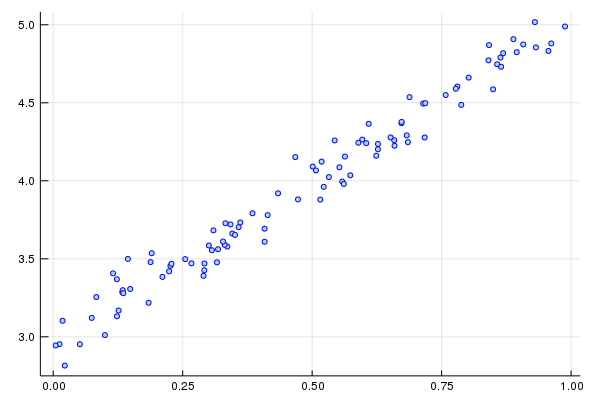

In [65]:
m = 100
x = rand(1,m)
y = 2x .+ 3 + randn(1,m) * 0.1
scatter(x, y, m=(stroke(1,:blue),:lightblue,3), leg=false)

In [66]:
using Flux
using Flux.Tracker: Params
using Flux: @epochs, throttle, mse
using Base.Iterators: repeated

model = Dense(1, 1)

#mse(ŷ, y) = sum(ŷ - y)^2 / size(y, 2)
loss(x, y) = mse(model(x), y)

data = repeated((x, y), 200)
evalcb = () -> @show(loss(x, y))

opt = ADAM(params(model), 0.1)

@epochs 2 Flux.train!(loss, data, opt,  cb=throttle(evalcb, 10))

loss(x, y) = 19.411147365010695 (tracked)
loss(x, y) = 0.009317259909229554 (tracked)


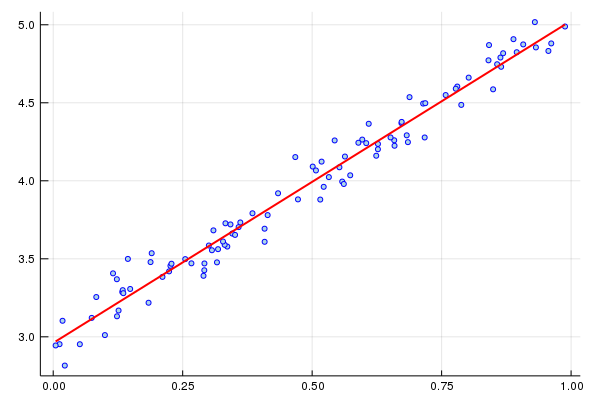

In [67]:
ŷ = Flux.data(model(x))
scatter(x, y, m=(stroke(1,:blue),:lightblue,3), leg=false)
plot!(x', ŷ', c=:red, lw=2)

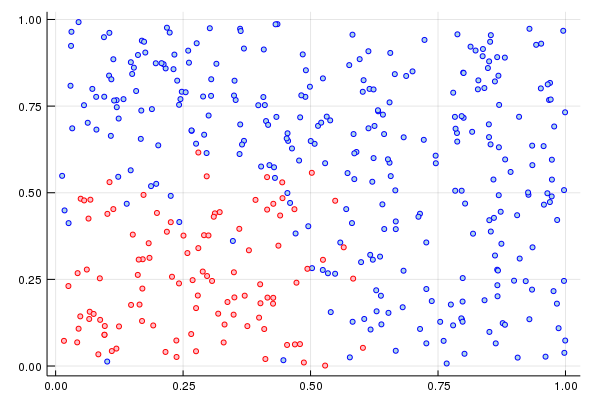

In [68]:
using Random
Random.seed!(0)
m = 400
x = rand(2, m)
y = [x[1,i]^4 + x[2,i]^4 + randn() * 0.05 > 0.1 ? 1 : 0 for i = 1:m]
P = findall(y .== 1)
N = findall(y .== 0)
y = y'
plot(leg=false)
scatter!(x[1,P], x[2,P], m=(stroke(1,:blue),:lightblue,3))
scatter!(x[1,N], x[2,N], m=(stroke(1,:red),:pink,3))

In [69]:
using Flux.Tracker: Params
using Flux: @epochs, throttle, binarycrossentropy
using Base.Iterators: repeated

model = Dense(2, 1, t->1/(1+exp(-t)))

ϵ = 1e-8
logvs(ŷ, y) = -y .* log.(ŷ .+ ϵ) - (1 .- y) .* log.(1 .+ ϵ .- ŷ)
loss(x, y) = sum(logvs(model(x), y)) / size(y, 2)

data = repeated((x, y), 200)
evalcb = () -> @show(loss(x, y))

opt = ADAM(params(model), 0.1)

@epochs 2 Flux.train!(loss, data, opt,  cb=throttle(evalcb, 10))

loss(x, y) = 0.7122345866733074 (tracked)
loss(x, y) = 0.2518519699969161 (tracked)


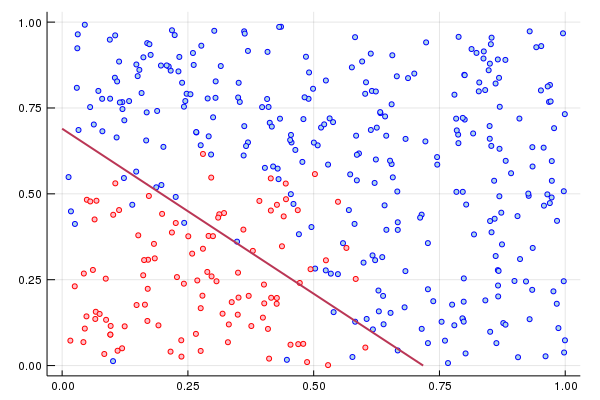

In [70]:
plot(leg=false)
scatter!(x[1,P], x[2,P], m=(stroke(1,:blue),:lightblue,3))
scatter!(x[1,N], x[2,N], m=(stroke(1,:red),:pink,3))
c(a,b) = Flux.data(model([a; b]))[1]
xgrid = range(0.0, stop=1.0, length=100)
contour!(xgrid, xgrid, c, levels=[0.5], lw=2)

## Camadas escondidas

- O poder da rede neural acontece quando colocamos camadas escondidas.
- Por exemplo, se temos uma entrada de 2 valores, e uma camada interna com mais 3 valores, e uma saída de um valor, temos, chamando de $z$ os valores da camada interna
$$ z_1 = \sigma_1(w_1^Tx + b_1) \qquad z_2 = \sigma_1(w_2^Tx + b_2), $$
$$ y = \sigma_2(w_3^Tz + b_3), $$
com os vetores $w_1$ e $w_2$ de dimensão 2, e o vetor $w_3$ de dimensão 3.
- Isso nos leva a 10 variáveis para encontrar, num problema de duas entradas e uma saída.
- A complexidade aumenta, e também o quanto pode ser representado pela rede neural.

**Exemplo com uma camada escondida**

loss(x, y) = 0.7541256514149783 (tracked)
loss(x, y) = 0.16569282578437736 (tracked)


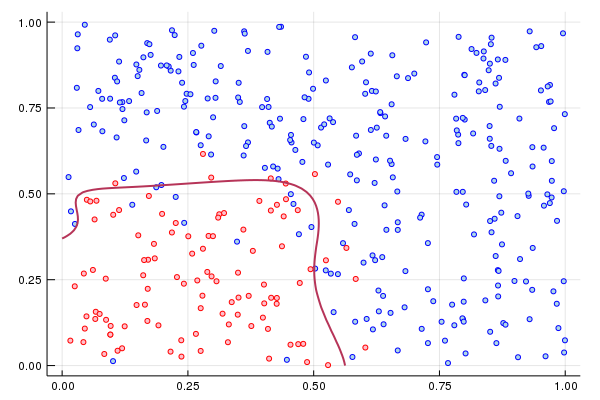

In [71]:
using Flux.Tracker: Params
using Flux: @epochs, throttle, binarycrossentropy
using Base.Iterators: repeated

tamanho_da_camada_escondida = 10
#sigmoid(t) = 1 / (1 + exp(-t))
model = Chain(
    Dense(2, tamanho_da_camada_escondida, sigmoid),
    Dense(tamanho_da_camada_escondida, tamanho_da_camada_escondida, sigmoid),
    Dense(tamanho_da_camada_escondida, tamanho_da_camada_escondida, sigmoid),
    Dense(tamanho_da_camada_escondida, 1, sigmoid)
)

ϵ = 1e-8
logvs(ŷ, y) = -y .* log.(ŷ .+ ϵ) - (1 .- y) .* log.(1 .+ ϵ .- ŷ)
loss(x, y) = sum(logvs(model(x), y)) / size(y, 2)

data = repeated((x, y), 200)
evalcb = () -> @show(loss(x, y))

opt = ADAM(params(model), 0.1)

@epochs 2 Flux.train!(loss, data, opt,  cb=throttle(evalcb, 10))

plot(leg=false)
scatter!(x[1,P], x[2,P], m=(stroke(1,:blue),:lightblue,3))
scatter!(x[1,N], x[2,N], m=(stroke(1,:red),:pink,3))
c(a,b) = Flux.data(model([a; b]))[1]
xgrid = range(0.0, stop=1.0, length=100)
contour!(xgrid, xgrid, c, levels=[0.5], lw=2)

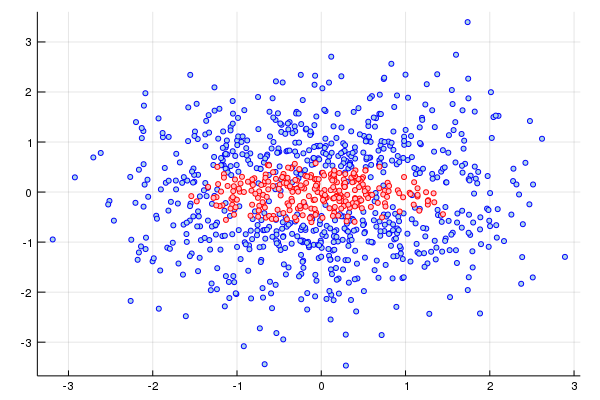

In [72]:
using Random
Random.seed!(0)
m = 1000
x = randn(2, m)
y = [x[1,i]^2 + 8x[2,i]^2 + randn() * 1.0 > 2.0 ? 1 : 0 for i = 1:m]
P = findall(y .== 1)
N = findall(y .== 0)
y = y'
plot(leg=false)
scatter!(x[1,P], x[2,P], m=(stroke(1,:blue),:lightblue,3))
scatter!(x[1,N], x[2,N], m=(stroke(1,:red),:pink,3))

In [73]:
using Flux.Tracker: Params
using Flux: @epochs, throttle, binarycrossentropy
using Base.Iterators: repeated


tamanho_da_camada_escondida = 3
#sigmoid(t) = 1 / (1 + exp(-t))
model = Chain(
    Dense(2, tamanho_da_camada_escondida, sigmoid),
    Dense(tamanho_da_camada_escondida, 1, sigmoid)
)

ϵ = 1e-8
logvs(ŷ, y) = -y .* log.(ŷ .+ ϵ) - (1 .- y) .* log.(1 .+ ϵ .- ŷ)
loss(x, y) = sum(logvs(model(x), y)) / size(y, 2)

data = repeated((x, y), 200)
evalcb = () -> @show(loss(x, y))

opt = ADAM(params(model), 0.1)

@epochs 2 Flux.train!(loss, data, opt,  cb=throttle(evalcb, 10))

loss(x, y) = 0.6533255004175677 (tracked)
loss(x, y) = 0.2029740018308139 (tracked)


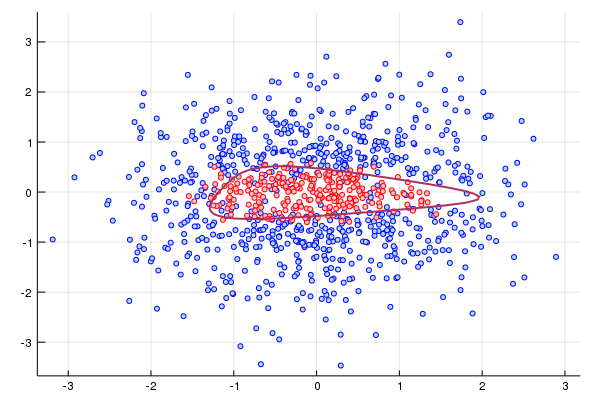

In [74]:
plot(leg=false)
scatter!(x[1,P], x[2,P], m=(stroke(1,:blue),:lightblue,3))
scatter!(x[1,N], x[2,N], m=(stroke(1,:red),:pink,3))
c(a,b) = Flux.data(model([a; b]))[1]
xgrid = range(-3.0, stop=3.0, length=100)
contour!(xgrid, xgrid, c, levels=[0.5], lw=2)

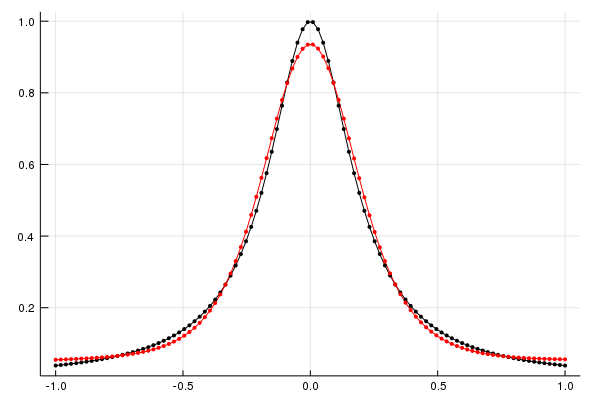

In [75]:
using Flux.Tracker: Params
using Flux: @epochs, throttle
using Base.Iterators: repeated

m = 100
f(x) = 1 / (1 + 25x^2)
x = reshape(range(-1.0, stop=1.0, length=m), 1, m)
y = f.(x)

tamanho_da_camada_escondida = 10

model = Chain(
    Dense(1, tamanho_da_camada_escondida, sigmoid),
    Dense(tamanho_da_camada_escondida, 1)
)

loss(x, y) = mse(model(x), y)

data = repeated((x, y), 1000)
opt = ADAM(params(model), 0.01)

@epochs 2 Flux.train!(loss, data, opt)

ŷ = Flux.data(model(x))

plot(leg=false)
plot!(x', y', c=:black)
plot!(x', ŷ', c=:red)
scatter!(x', y', c=:black, ms=3, m=(stroke(0)))
scatter!(x', ŷ', c=:red, m=(stroke(0)), ms=3)

## Otimização de uma rede

- Um modelo de rede é essencialmente uma sequência de funções compostas.
- Chamando a primeira camada de $z_0 = x$, a próxima camada inicialmente é obtida pela combinação linear de cada termo $z_0$ acrescido do viés: $a_1 = W_1 z_0 + b_1$.
- Agora, com a combinação linear, fazemos a aplicação da função de ativação, obtendo $z_1 = \sigma_1(a_1)$.
- Isso se repete, obtendo
$$ a_i = W_i z_{i-1} + b_i \qquad z_i = \sigma_i(a_i), $$
- A última camada é a de saída $y = z_N$.

Por exemplo, numa camada de entrada 2, com 3 camadas intermediárias, e uma de saída:

In [76]:
x = rand(2)
z0 = x
W1 = randn(3, 2) # 2 -> 3
b1 = randn(3)
a1 = W1 * z0 + b1
σ1(t) = 1 / (1 + exp(-t))
z1 = σ1.(a1)
W2 = randn(1, 3) # 3 -> 1
b2 = randn(1)
a2 = W2 * z1 + b2
σ2(t) = t
z2 = σ2.(a2)

z0, z1, z2

([0.280871, 0.141131], [0.737148, 0.508657, 0.317286], [-0.729839])

$$ h(x) = \sigma_2(W_2 \sigma_1(W_1 x + b_1) + b_2). $$

Dado uma função de perda, $\ell(\hat{y}, y)$, e a função objetivo
$$ L(W, b) = \frac{1}{m}\sum_{i = 1}^m \ell(h(x^i), y^i), $$
aplicamos um método de otimização para minimizar $L$, encontrando $b_1, b_2, W_1$ e $W_2$.

Para tanto, precisamos calcular as derivadas de $L$ em relação à cada variável, e para isso precisamos das derivadas de $h$.

As derivadas de $h$ seguirão a regra da cadeia, então temos que calcular derivada em cima de derivada. Além disso, ainda precisamos calcular o valor de cada termo intermediário $z_i$. Esse calculo da derivada é chamado de **backpropagation**, pela maneira que podemos visualizá-lo.

**Backpropagation** também é usado para descrever o algoritmo de atualizar os pesos de uma rede, no entanto, na prática estamos calculando a derivada e utilizando essa derivada num método, que pode ser o gradiente, ou gradiente estocástico.

### Referência

Para os interessados nos detalhes, a melhor referência visual que achei até agora é esta playlist de ~1h do 3Blue1Brown: https://www.youtube.com/playlist?list=PLZHQObOWTQDNU6R1_67000Dx_ZCJB-3pi

Nela, ele mostra a ideia básica da rede, do método do gradiente, do backpropagation, e a conta para encontrar os valores.